In [1]:
import torch
import pdb
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchviz import make_dot

In [2]:
def show(tensor, ch=1, size=(28, 28), num=16):
    data = tensor.detach().cpu().view(-1, ch, *size) # (batch size, channels, height, width)
    grid = make_grid(data[:num], nrow=4).permute(1, 2, 0) # (num, height, width, channels)
    plt.imshow(grid)
    plt.show()

In [3]:
epochs = 500
cur_step = 0
info_step = 300

mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64

lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

batch_size = 128
device = "cuda"

dataloader = DataLoader(MNIST("G:\Datasets", download=True, transform=transforms.ToTensor()),batch_size=128, shuffle=True)

# no. of steps = total images / batch size
# here, steps = 60000 / 128 = 468.75

In [4]:
def genBlock( inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)    
    )

class Genrator(nn.Module):
    def __init__(self, z_dim=64, o_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), # 64 , 128
            genBlock(h_dim, h_dim*2), # 128, 256
            genBlock(h_dim*2, h_dim*4), # 256, 512
            genBlock(h_dim*4, h_dim*8), # 512, 1024
            genBlock(h_dim*8, h_dim*8), # 1024, 1024
            nn.Linear(h_dim*8, o_dim), # 1024, 784
            nn.Sigmoid()   
        )
        
    def forward(self, noise):
        return self.gen(noise)
    
def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device)

In [5]:
def discBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.LeakyReLU(0.2)    
    )

class Discriminator(nn.Module):
    def __init__(self, o_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            discBlock(o_dim, h_dim*8), # 784 , 1024
            discBlock(h_dim*8, h_dim*4), # 1024, 512
            discBlock(h_dim*4, h_dim*2), # 512, 256
            discBlock(h_dim*2, h_dim), # 256, 128
            nn.Linear(h_dim, 1), # 128, 1
        )
        
    def forward(self, image):
        return self.gen(image)

In [6]:
gen = Genrator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
noise = gen_noise(1, z_dim)
output = Genrator(noise)
graph = make_dot(output, params=dict(Genrator.named_parameters()))
graph.render('generator_model', format='png')

In [7]:
gen

Genrator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, 

In [8]:
disc

Discriminator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [9]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:20])

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([5, 9, 0, 5, 6, 1, 3, 1, 8, 8, 4, 8, 1, 0, 2, 6, 3, 1, 0, 0])


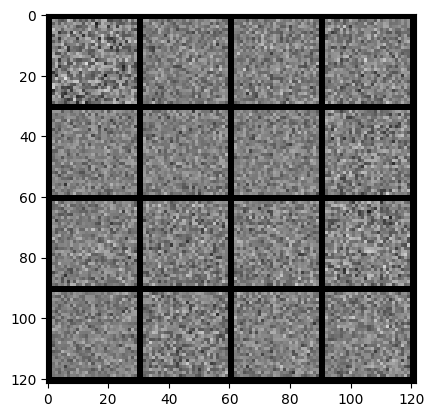

In [10]:
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

In [13]:
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    pred = disc(fake)
    targets = torch.ones_like(pred)
    gen_loss = loss_func(pred, targets)
    
    return gen_loss

In [14]:
def calc_disc_loss(loss_func, gen, disc, number, z_dim, real):
    
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    
    pred_fake = disc(fake.detach())
    pred_fake_targets = torch.zeros_like(pred_fake)
    pred_fake_loss = loss_func(pred_fake, pred_fake_targets)
    
    pred_real = disc(fake.detach())
    pred_real_targets = torch.ones_like(pred_real)
    pred_real_loss = loss_func(pred_real, pred_real_targets)
    
    disc_loss = (pred_real_loss + pred_fake_loss) / 2
    
    return disc_loss



In [15]:
for epoch in range(epochs):
    for real_img, labels in tqdm(dataloader):
        
        cur_bs = len(real_img)
        real_img = real_img.view(cur_bs, -1)
        
        ### Discrimnator
        disc_opt.zero_grad()
        real_img = real_img.to(device)
        
        disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, z_dim, real_img)
        
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        ### Generator
        gen_opt.zero_grad()
        
        gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
        
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        
        ### visualisation & stats
        mean_disc_loss += disc_loss.item()/info_step
        mean_gen_loss += gen_loss.item()/info_step
        
        if cur_step % info_step == 0 and cur_step > 0:
            fake_noise = gen_noise( cur_bs, z_dim)
            fake = gen(fake_noise)
            show(fake)
            show(real_img)
            print("Epoch =",epoch,"cur_step =",cur_step, "disc_loss =",mean_disc_loss, "gen_loss =",mean_gen_loss  )
            mean_gen_loss = 0
            mean_disc_loss = 0
        
        cur_step += 0

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 